# Decision plot

Decision plot은 머신러닝 모형의 내부적 작동원리와 예측구조를 좀 더 세밀하고 상세하게 설명하는 데 중점을 두고 있다. Decision plot의 중요 내용을 정리하면 다음과 같다.  
- 좀 더 명확하고 세밀한 설명변수의 shap value 시각화  
- 다중 출력을 시각화  
- Interaction Shap value 효과와 누적효과를 시각화  
- 일정 범위에 있는 설명변수의 Shap value 탐색 가능  
- 2개 이상의 머신러닝 모형의 예측 결과 비교 시각화  
- 특성 예측 패턴을 가진 표본을 추출하고 탐색하는 기능

이 여섯 가지 내용에 대해 사례를 통해 논의하고, 기타 중요한 사항을 살펴본다.

---

census 데이터인 adult 데이터를 호출한다. X_display, y_display는 12개의 설명변수 중 범주형인 7개 설명변수를 string으로 정의하고 있다. X,y는 범주형 설명변수를 one-hot-encoding하여 분석에 활용되는 데이터이다.

In [47]:
import numpy as np
import pandas as pd

import shap

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [48]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

다음으로 `LightGBM`을 적용하고 학습시킨다.

In [49]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

eval_set = [(X_test,y_test)]
lgb = LGBMClassifier(n_estimators=997,learning_rate=0.05,max_depth=3,colsample_bytree=0.842,min_child_weight=2,subsample=0.8)

model=lgb.fit(X_train,y_train,verbose=False)

y_pred = model.predict(X_test)

In [50]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" %(accuracy*100.0) )

Accuracy: 87.44%


다음은 X_test의 첫 20개 표본을 추출하여 이 20개 표본에 대한 Shap value를 구하기 위해 features로 정의하고, 범주형 설명변수 값을 텍스트로 표현하기 위해 `features_display`를 X_display로부터 정의한다.

In [51]:
select = range(20)
features = X_test.iloc[select]
features_display = X_display.iloc[features.index]

9장에서 논의했지만 `TreeExplainer`는 intervention 방법 또는 tree_path_dependent 방법을 적용하여 SHAP value를 구할 수 있다. tree_path_dependent 방법이 SHAP을 구하기 위해 사용하는 조건부 분포에 가깝고 별도의 shap value를 구하기 위한 background 데이터를 지정할 필요가 없으며, `Catboost` 모형의 경우 intervention을 사용하면 error를 발생시키고, 특히 교호작용 Shap value를 모두 0으로 추정하는 오류가 발생하므로 가급적 tree_path_dependent를 사용할 것을 권장한다. 이미 언급하였듯이 교호작용 Shap value는 오직 `TreeExplainer`에서만 사용가능하다. 아래 결과에서 볼 수 있듯이 label이 2개이므로 expected_value는 label 1의 $E(f(x))$의 추정치를 나타낸다.

In [52]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

다음 코드는 label 1에 대한 expected_value, shap_values[1]을 decision_plot의 첫 번째, 두 번째 입력으로 지정하고 세 번째 입력에 설명변수 이름을 가지고 있는 feature_display를 지정하면 20개 표본 각각에 대해 다음과 같은 plot을 출력한다.

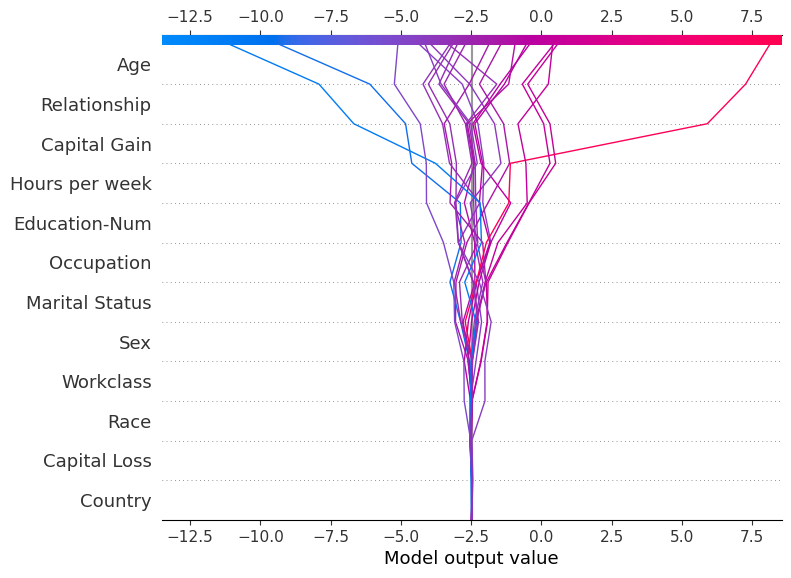

In [53]:
shap.decision_plot(explainer.expected_value, shap_values[1], features_display)

위 그림에서 y축은 설명변수 중요도의 내림차순으로 설명변수를 배열하고 있다. 설명변수의 중요도는 shap value 절댓값의 평균으로 계산한다. x축의 출발점은 expected_value이고 상단부의 x축으로 올라가면서 각 설명변수의 Shap value의 누적합을 진행한다. 상단부의 x축에 도달하면 그 값은 각 표본에 대한 예측치가 된다. 여기에서 예측치는 log odds 값으로 이 값을 sigmoid 함수에 대입하면 표본이 label 1에 속할 확률이 된다.

다음 코드는 log odds 대신 x축의 하단부와 상단부를 확률로 교체한 그림이다. `link='logit'`으로 옵션을 지정하면 된다.

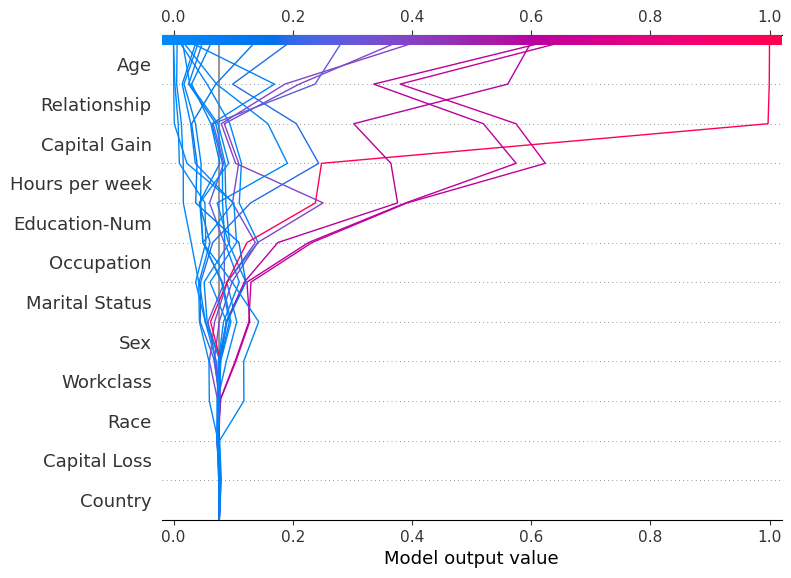

In [54]:
shap.decision_plot(explainer.expected_value,shap_values[1],features_display,link='logit')

다음으로 , 예측이 틀린 12번째 표본을 점 연결선으로 표시할 수 있도록 `highlight=12`로 지정한다.

[False False False False False False False False False False False False
  True False False False False False False False]


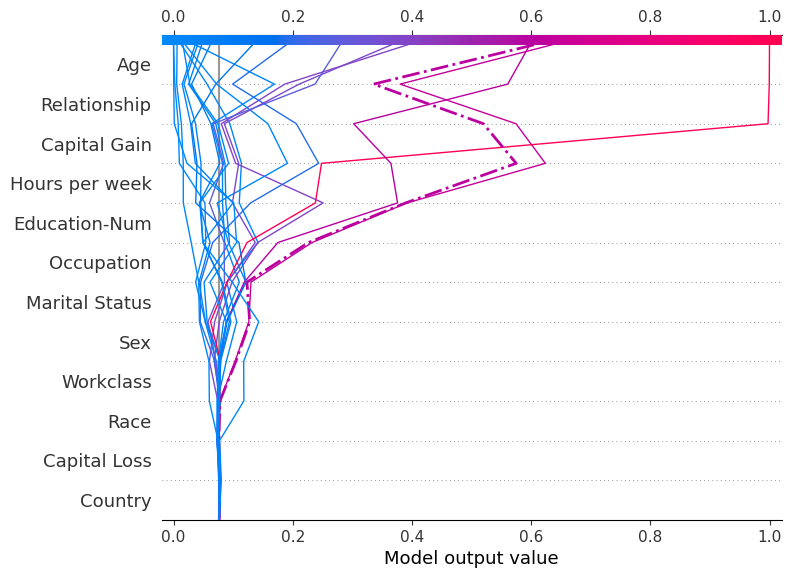

In [55]:
expected_value = explainer.expected_value
y_pred = model.predict(features)

misclassified = y_pred != y_test[select]
print(misclassified)

shap.decision_plot(expected_value, shap_values[1],features_display,link='logit',highlight=12)

다음으로 Boolean 데이터인 misclassified를 이용하여 12번째 표본만 decision_plot으로 그린 그림으로, Shap value가 오직 1개이면 feature_display의 설명변수 값을 아래와 같이 출력한다. features_display 대신 features를 지정하면 one-hot encoding 값을 출력하므로 범주형 설명변수 값을 알 수 없다.

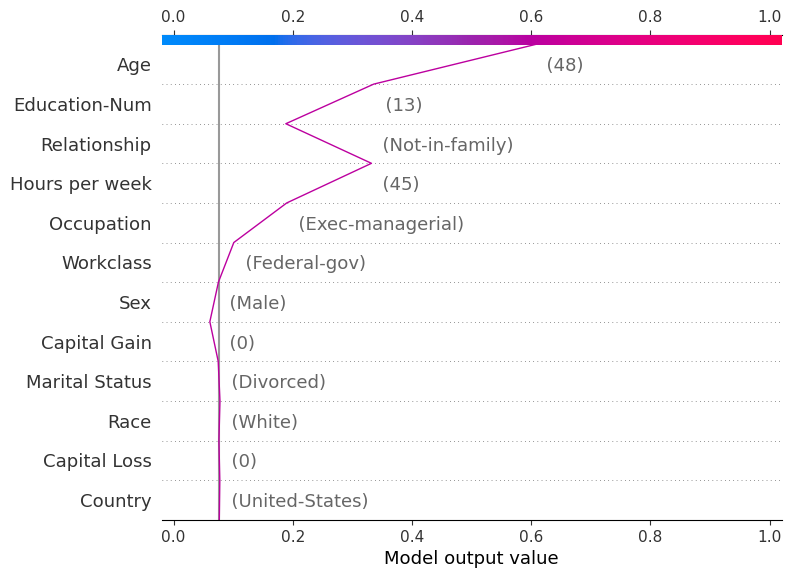

In [56]:
shap.decision_plot(expected_value,shap_values[1][misclassified],
                   features_display[misclassified],link='logit')

다음은 직전 decision_plot과 동일한 정보를 주는 force_plot이다. 출력은 log odds 값이므로 약간의 차이가 있다. force_plot은 link='logit'와 같은 옵션이 없기 때문에 출력을 확률로 바꿀 수 없다. decision_plot과 동일한 정보를 제공하지만 설명변수가 많아지만 force_plot의 해석력은 현저하게 떨어진다는 단점이 있다.

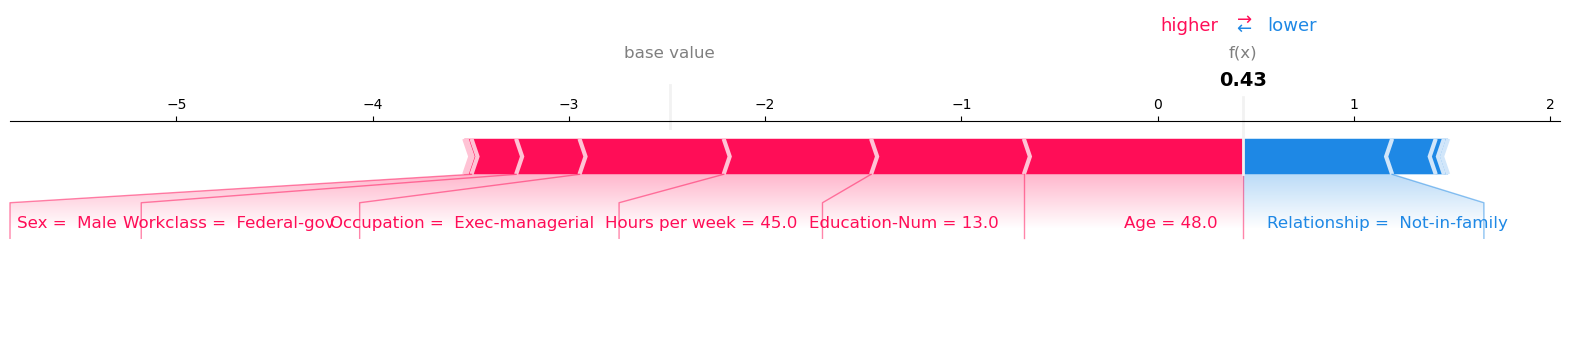

In [57]:
shap.force_plot(expected_value,shap_values[1][12],features_display[misclassified],matplotlib=True)

다음 프로그램은 $\frac{k(k+1)}{2}=12/2 = 78$개의 교호작용(주 효과 포함)을 Shap value 절댓값 평균으로 평가한 중요도의 내림차순으로 가장 기여도가 큰 20개의 교호작용을 default로 보여준다. `feature_display_range` 옵션으로 20개 이상의 교호작용 SHAP value의 출력을 지정할 수 있다. 모든 Shap value를 plot하지 않았기 때문에 expected_value가 x축 하단부에 나타나지 않아 수렴하지 않은 것처럼 나타났다.

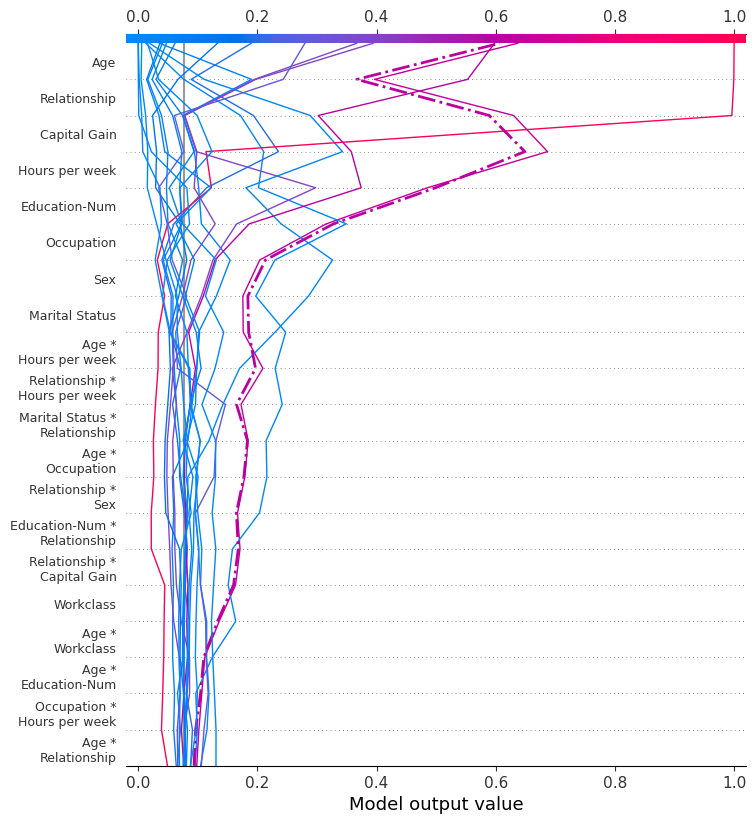

In [58]:
shap.decision_plot(expected_value,shap_interaction_values,features_display,highlight=misclassified,link='logit')

다음은 예측이 틀린 12번째 표본에 대한 interaction SHAP value를 보여준다.

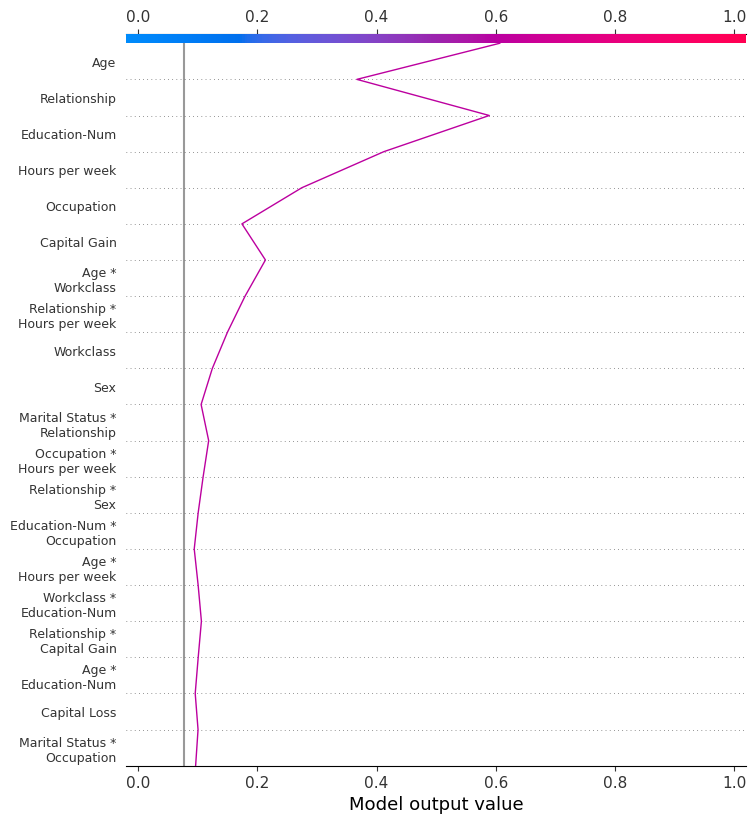

In [59]:
shap.decision_plot(expected_value,shap_interaction_values[misclassified],features_display[misclassified],link='logit')

다음은 특정 표본의 설명변수 값을 변화시켰을 때 예측치의 영향을 살펴보고자 하는 코드이다. `np.repeat`를 이용하여 25번째 표본을 100번 반복하여 복사한 후, 설명변수 Capital Gain 값을 0부터 100씩 증가시킨 값으로 대체한 (100,12) 데이터 R을 정의한다. 해당 데이터에 대한 Shap value를 산출한 후, 목적값의 label 1의 Shap value를 hypothetical_shap_values으로 정의한다.

In [60]:
idx = 25
rg =range(0,10000,10)
R = X.iloc[np.repeat(idx,len(rg))].reset_index(drop=True)

print(R.shape)
R['Capital Gain'] = rg

(1000, 12)


In [61]:
hypothetical_shap_value = explainer.shap_values(R)[1]
hypothetical_predictions = expected_value + hypothetical_shap_value.sum(axis=1)
hypothetical_predictions = 1 / (1+np.exp(-hypothetical_predictions))

다음은 100개의 시나리오 표본에 대한 예측경로(Prediction path)를 보여준다. `feature_order='hclust'`으로 지정하면 예측경로가 비슷한 표본들을 군집으로 모아 plot을 만든다. 원래의 25번째 관측치는 0번째에 있도록 하였으므로 highlight=0으로 지정하여 점선으로 그린다.

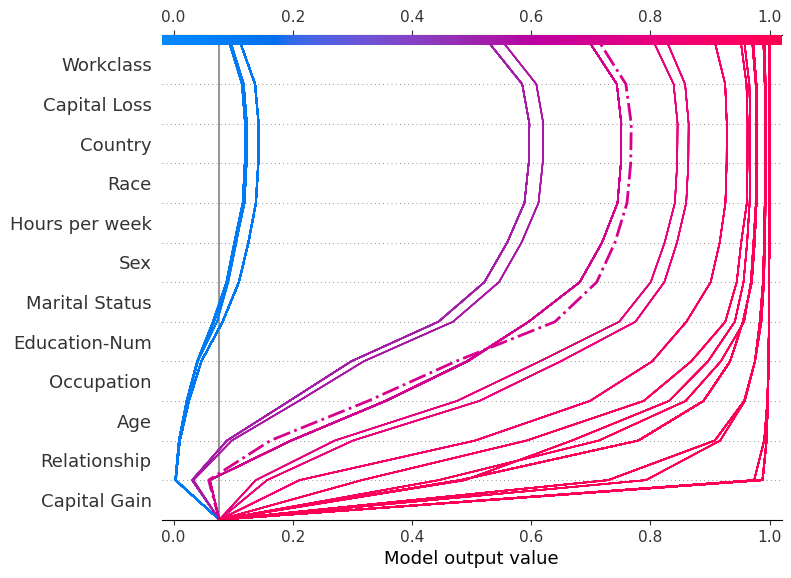

In [62]:
shap.decision_plot(expected_value,hypothetical_shap_value,R,link='logit',feature_order='hclust',highlight=0)

다음은 25번째 표본에 대한 `Shap value(hypothetical_shap_values[0])`의 예측경로를 그린다. `feature_idx`를 지정하여 직전 plot의 설명변수 중요도 순서를 유지하여 비교가능하도록 한다.

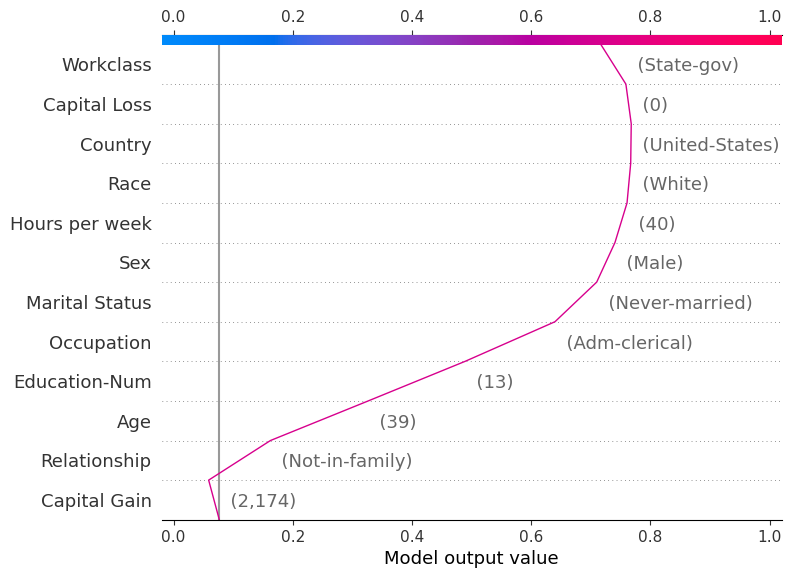

In [63]:
feature_idx = [8,5,0,2,4,3,7,10,6,11,9,1]

shap.decision_plot(expected_value,hypothetical_shap_value[0],X_display.iloc[0],feature_order=feature_idx,link='logit')

설명변수 Capital Gain의 효과를 좀 더 뚜렷하게 살펴보기 위해 데이터 R에서 [0,30,40,50]을 선택하여 plot을 그리면 다음과 같다.

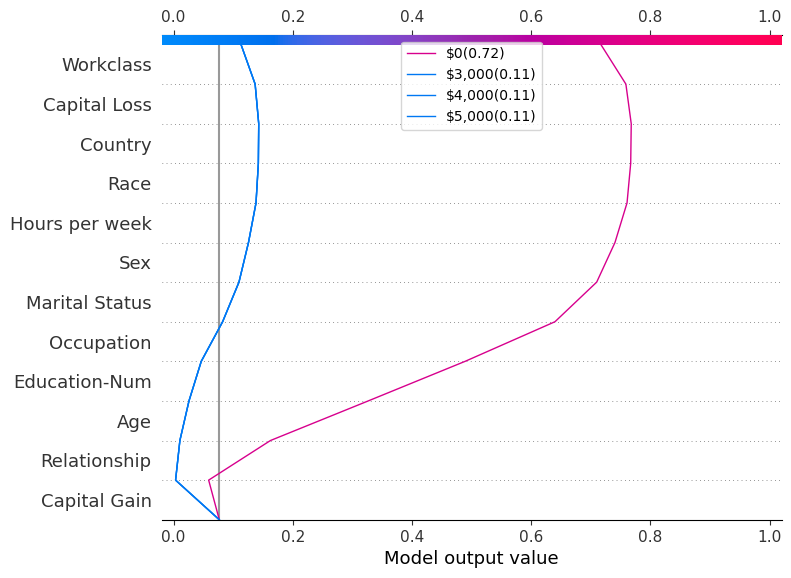

In [64]:
def legend_labels(idx):
    return [f'\${i * 100:,}({hypothetical_predictions[i]:.2f})' for i in idx]

show_idx = [0,30,40,50]

shap.decision_plot(expected_value,hypothetical_shap_value[show_idx],X,
                   feature_order=feature_idx,link='logit',
                   legend_labels=legend_labels(show_idx),legend_location='upper center')

다음은 시험데이터 X_test에서 label 1에 속할 확률이 아주 작은 $(0.03\le\  y_{pred}\ \le 0.1)$ 표본을 모아 이를 T로 지정하고 이 데이터에 대한 Shap value를 구한다. `return_objects=True` 옵션을 부여하면 `shap.decision_plot`을 객체화하여 plot의 구조를 공유할 수 있다. 동일한 Shap value의 순서와 scale을 유지하여 다음 분석과의 비교를 용이하도록 하기 위함이다.  
아래 그림에서 볼 수 있듯이 설명변수 Age의 효과가 음의 방향으로 매우 큰 표본이 있는 것으로 보인다.

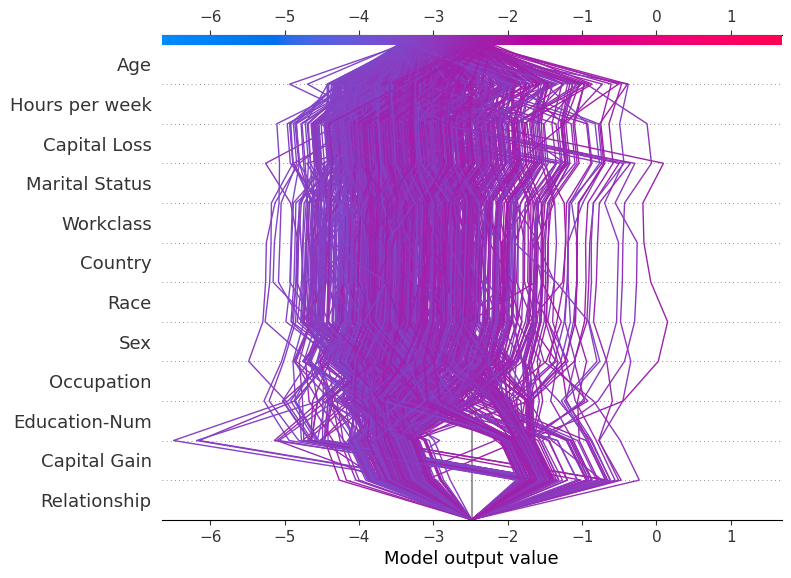

In [66]:
y_pred = model.predict_proba(X_test)
T = X_test[(y_pred[:,1] >= 0.03) & (y_pred[:,1]<=0.1)]

sh = explainer.shap_values(T)[1]
r = shap.decision_plot(expected_value,sh,T,feature_order='hclust',return_objects=True)

다음은 `np.argpartition(x[:,i],k)`를 통해 데이터 x의 i번째 설명변수 값을 기준으로 k번째 작은 값보다 작은 표본은 왼쪽으로, 크면 오른쪽으로 분리할 수 있다. 그러므로 다음 코드는 설명변수 Age의 Shap value를 기준으로 가장 작은 두 개 표본의 index를 idx로 정의하고 이 두 표본에 대한 예측 경로를 차례로 보여준다. 

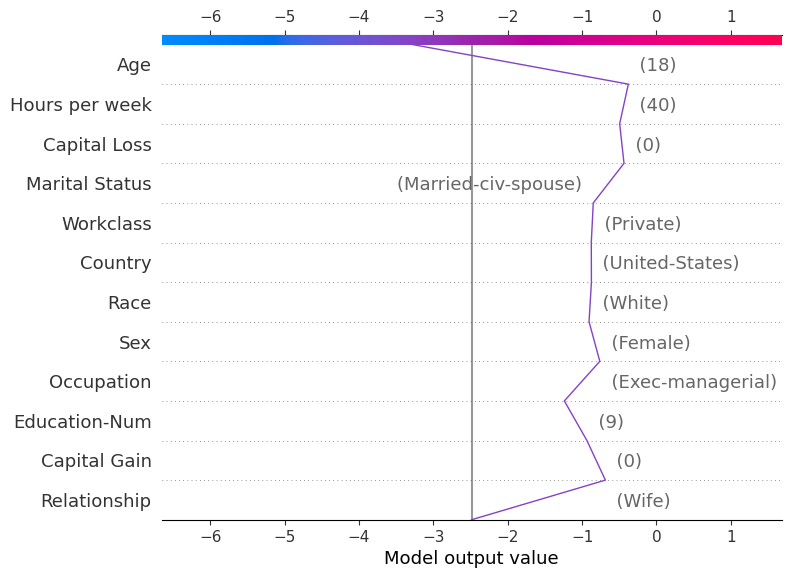

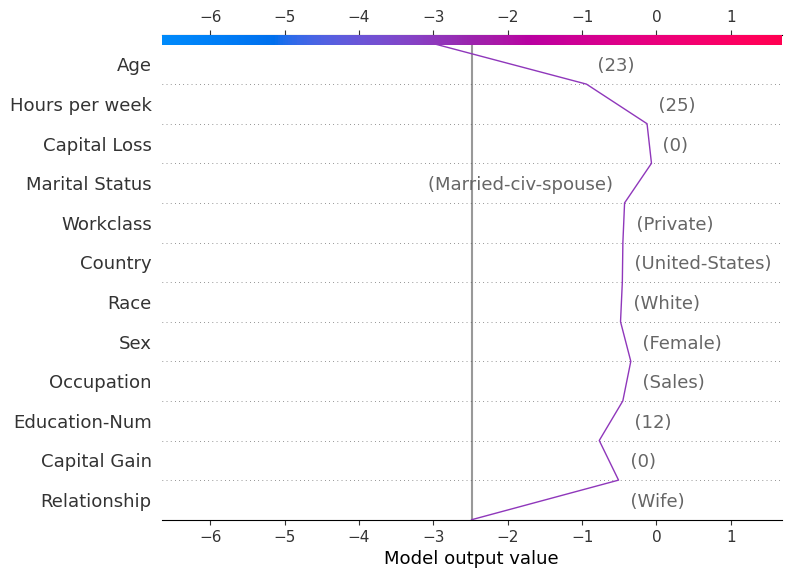

In [67]:
idx = np.argpartition(sh[:,T.columns.get_loc('Age')],2)[0:2]

for i in idx:
    shap.decision_plot(expected_value,sh[i],X_display.loc[T.index[i]],
                       feature_order = r.feature_idx, xlim = r.xlim)

위의 그림에서 볼 수 있듯이, Age,Hours per week, Education-Num만 약간 차이가 있을 뿐 다른 설명변수 값이 모두 동일한 것을 관찰할 수 있다.